In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Data Description

Here we have data from 2 Deep Mutational Scanning experiments ...TODO

# Data Summary Stats

First load in the data and do a little cleanup

In [6]:
C19 = pd.read_csv("../data/CYP2/CYP2C19_data_bc_corrected.csv")
C9 = pd.read_csv("../data/CYP2/CYP2C9_data_bc.csv")

append df's and add condition id, rename for MultiDmsData

In [7]:
rename_map = {
    "variant" : "aa_substitutions"
}
func_score_df = pd.concat(
    [
        C19.assign(condition="C19"), 
        C9.assign(condition="C9")
    ]
).rename(rename_map,axis=1)

remove 'syn' mutants

In [8]:
func_score_df = func_score_df[~func_score_df.aa_substitutions.str.contains("syn")]

conform 'X' -> '*' for stop codon variants

In [9]:
func_score_df = func_score_df.assign(aa_substitutions = func_score_df.aa_substitutions.str.replace("X", "*"))

add log fold change of weighted average.

In [10]:
func_score_df = func_score_df.assign(log_fold_wa = onp.log2(func_score_df.weighted_average / func_score_df.wt_wa))

In [11]:
func_score_df

,replicate,sort,barcode,weighted_average,total_reads,freq,type,med_nonsense,wt_wa,abundance_score,aa_substitutions,start,position,end,condition,log_fold_wa
0,Rep1,1.0,AAAAAAAACTACGTTCCA,0.979031,352,0.000013,missense,0.270414,0.900006,1.125517,S162R,S,162,R,C19,0.121419
1,Rep1,1.0,AAAAAAAATCCTAGCCGT,0.637117,421,0.000013,missense,0.270414,0.900006,0.582444,D373R,D,373,R,C19,-0.498378
2,Rep1,1.0,AAAAAAAATTTTGAAAGA,0.581670,1675,0.000054,missense,0.270414,0.900006,0.494377,D360K,D,360,K,C19,-0.629734
3,Rep1,1.0,AAAAAAACTATTGACTTC,0.782963,262,0.000012,missense,0.270414,0.900006,0.814096,L71G,L,71,G,C19,-0.200991
4,Rep1,1.0,AAAAAAATACAGGTTAAT,0.281605,747,0.000068,nonsense,0.270414,0.900006,0.017776,E274*,E,274,X,C19,-1.676260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149377,Rep3,NaN,TTTTTTTTGAAAGTCAAG,0.706138,188,0.000070,missense,0.423188,0.701742,1.015779,K247A,K,247,A,C9,0.009008
149378,Rep3,NaN,TTTTTTTTGCCAACGAAG,0.647242,166,0.000065,missense,0.423188,0.701742,0.804345,D191T,D,191,T,C9,-0.116636
149379,Rep3,NaN,TTTTTTTTGTAATTCTTG,0.692603,103,0.000038,missense,0.423188,0.701742,0.967191,Q193L,Q,193,L,C9,-0.018912
149380,Rep3,NaN,TTTTTTTTGTACGTACTT,0.496281,104,0.000044,missense,0.423188,0.701742,0.262400,G332S,G,332,S,C9,-0.499785


Summary stats of quantitative columns

In [21]:
func_score_df.describe()

,sort,weighted_average,total_reads,freq,med_nonsense,wt_wa,abundance_score,position,log_fold_wa
count,739960.000000,883130.000000,883130.000000,8.831300e+05,883130.000000,883130.000000,883130.000000,883130.000000,883130.000000
mean,1.709882,0.643444,534.840240,4.218686e-05,0.310452,0.802338,0.685401,231.831060,-0.378151
std,0.700311,0.185579,569.967683,4.137437e-05,0.049859,0.090649,0.394379,128.113406,0.471019
min,1.000000,0.250000,1.000000,1.830817e-08,0.270414,0.666583,-0.701318,1.000000,-1.879230
25%,1.000000,0.500000,143.000000,1.543936e-05,0.281263,0.703754,0.396703,129.000000,-0.641114
50%,2.000000,0.658633,344.000000,3.087995e-05,0.291621,0.806834,0.716826,230.000000,-0.273317
75%,2.000000,0.782434,738.000000,5.485879e-05,0.338143,0.891545,0.964539,341.000000,-0.031043
max,3.000000,1.000000,10376.000000,7.470403e-04,0.437047,0.919696,2.110753,490.000000,0.585142


**Why** is there so much more data for C19?

In [23]:
func_score_df.condition.value_counts()

C19    739960
C9     143170
Name: condition, dtype: int64

In [52]:
func_score_df.query("condition == 'C19'").replicate.value_counts()

Rep1    318813
Rep2    212375
Rep3    208772
Name: replicate, dtype: int64

In [53]:
func_score_df.query("condition == 'C9'").replicate.value_counts()

Rep2    48946
Rep3    48927
Rep1    45297
Name: replicate, dtype: int64

## Functional scores distributions

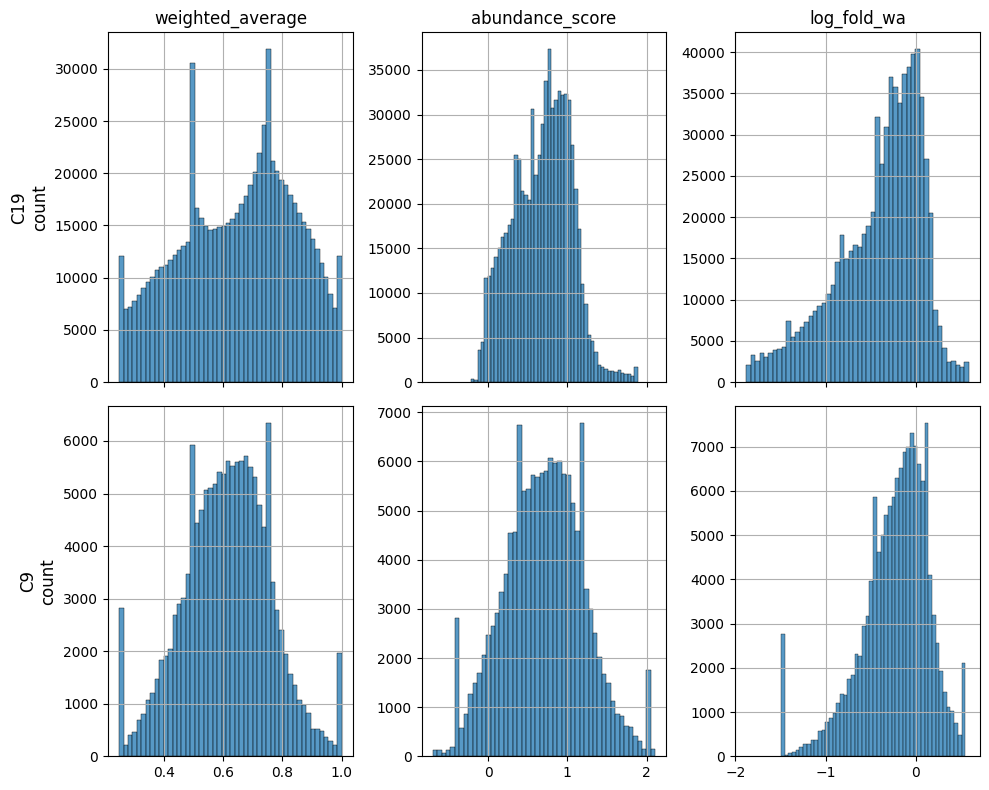

In [146]:
targets = ["weighted_average", "abundance_score", "log_fold_wa"]
fig, ax = plt.subplots(
    len(func_score_df.condition.unique()),
    len(targets),
    sharex="col",
    figsize=[10, 8]
)
for row, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    for col, target in enumerate(targets):
        sns.histplot(condition_df, x=target, ax=ax[row, col], bins=50)
        ax[row, col].grid()
        ax[row, col].set_xlabel("")
        ax[row, col].set_ylabel("")
        if col == 0:
            ax[row, col].set_ylabel(f"{condition}\ncount", size=12)
        if row == 0:
            ax[row, col].set_title(target)
plt.tight_layout()
plt.show()

## Barcodes

First, we'll look at the number of barcodes per variant

In [149]:
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    vc = condition_df.aa_substitutions.value_counts()
    print(condition,'\n',vc.describe())

C19 
 count    8472.000000
mean       87.341832
std       112.660560
min         2.000000
25%        21.000000
50%        49.000000
75%       110.000000
max      2559.000000
Name: aa_substitutions, dtype: float64
C9 
 count    8308.000000
mean       17.232788
std        18.415688
min         1.000000
25%         6.000000
50%        12.000000
75%        21.000000
max       249.000000
Name: aa_substitutions, dtype: float64


In [165]:
list(range(0, 10, 2))

[0, 2, 4, 6, 8]

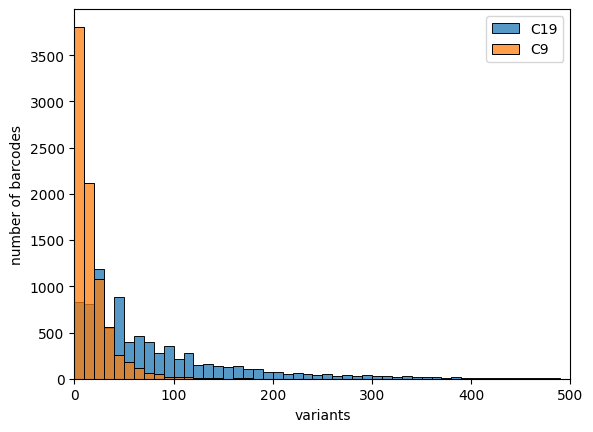

In [167]:
fig, ax = plt.subplots()
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    vc = condition_df.aa_substitutions.value_counts().reset_index()
    sns.histplot(vc, x="aa_substitutions", ax=ax, bins=range(0, 500, 10), label=condition)
    ax.set_ylabel("number of barcodes")
    ax.set_xlabel("variants")
    ax.set_xlim([0, 500])
    ax.legend()

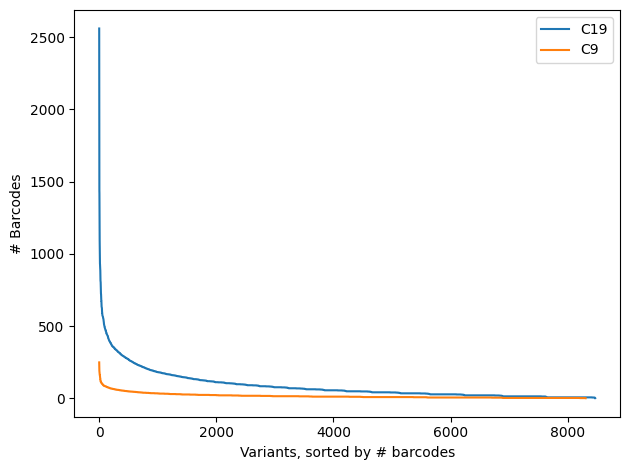

In [87]:
fig, ax = plt.subplots()
for col, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    vc = condition_df.aa_substitutions.value_counts()
#     print(f"{condition} \n{vc[:5]}\n{vc[-5:]}")
    ax.plot(vc.values, label=condition)
    ax.set_ylabel("# Barcodes")
    ax.set_xlabel("Variants, sorted by # barcodes")
#     ax.set_title(condition)
ax.legend()
plt.tight_layout()
plt.show()

Next, let's look at the stoachasticity to expect by number of barcodes

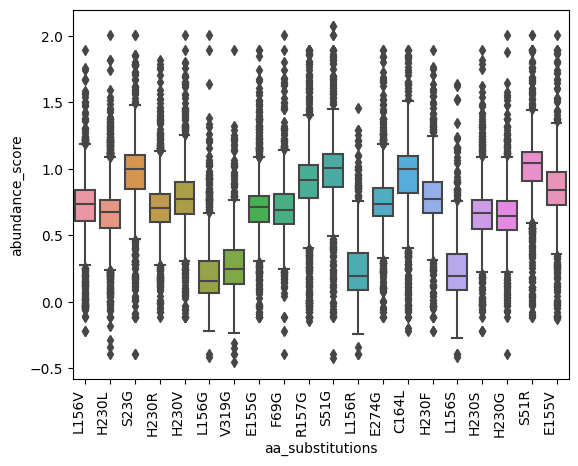

In [168]:
fig, ax = plt.subplots()
subs = func_score_df.aa_substitutions.value_counts()[:20].index
subs_fs = func_score_df.query(f"aa_substitutions.isin({list(subs)})")
sns.boxplot(subs_fs, x="aa_substitutions", y="abundance_score", ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

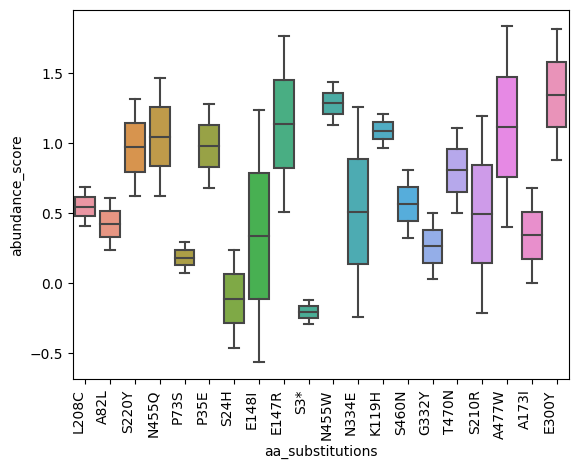

In [169]:
fig, ax = plt.subplots()
subs = func_score_df.aa_substitutions.value_counts()[-20:].index
subs_fs = func_score_df.query(f"aa_substitutions.isin({list(subs)})")
sns.boxplot(subs_fs, x="aa_substitutions", y="abundance_score", ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
plt.show()

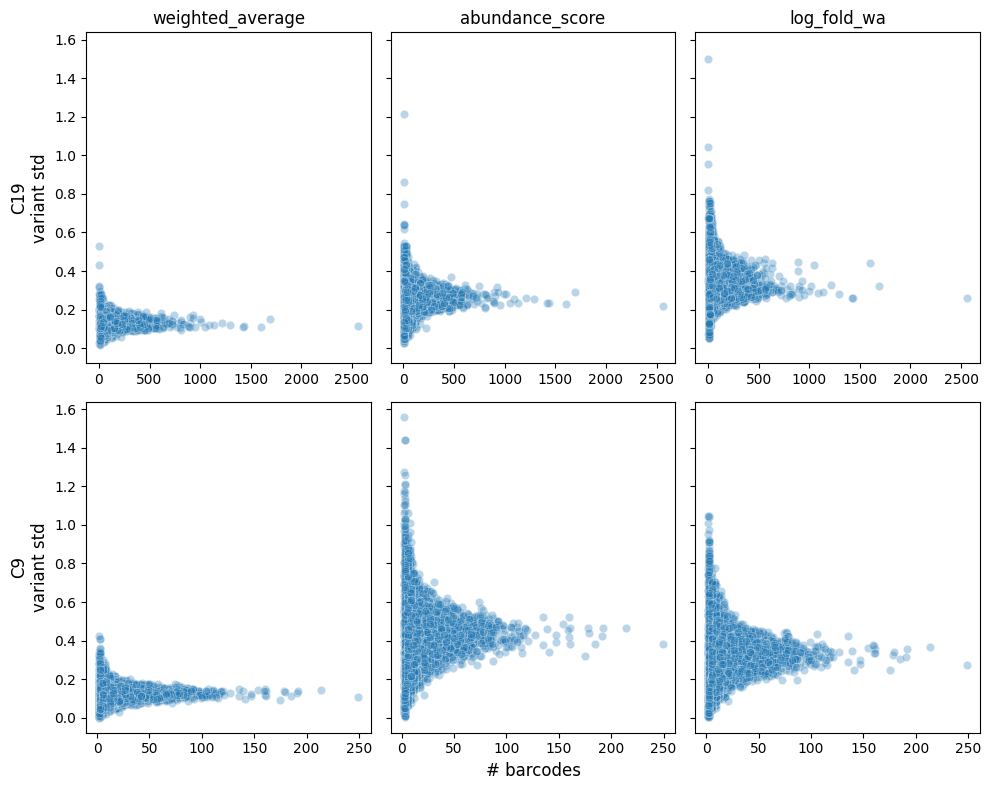

In [153]:
targets = ["weighted_average", "abundance_score", "log_fold_wa"]
fig, ax = plt.subplots(
    len(func_score_df.condition.unique()),
    len(targets),
    sharey=True,
    figsize=[10, 8]
)
for row, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    for col, target in enumerate(targets):
        cv = condition_df.groupby("aa_substitutions").agg({"barcode":lambda x: len(x), target:onp.std})
        sns.scatterplot(cv,x="barcode", y=target, ax = ax[row, col], alpha=0.3)
        ax[row, col].set_xlabel("")
        ax[row, col].set_ylabel("")
        if col == 0:
            ax[row, col].set_ylabel(f"{condition}\nvariant std", size=12)
        if row == 0:
            ax[row, col].set_title(target)
        if row == 1 and col == 1:
            ax[row, col].set_xlabel("# barcodes", size=12)
plt.tight_layout()
plt.show()

# Prep `MultiDmsData` Objects for single homolog models

In [94]:
prep_params = {
    # pre-processing params
#     "scale_counts" : False,
#     "pseudocount" : 0.1,
#     "sample" : False,
#     "min_pre_counts" : 100,
#     "clip_target" : (-3.5, 2.5),
#     "trim" : False
}

In [95]:
datasets = pd.DataFrame()

Intantiate `MultiDmsData` Object

In [97]:
targets = ["abundance_score", "log_fold_wa"]
for row, (condition, condition_df) in enumerate(func_score_df.groupby("condition")):
    for col, target in enumerate(targets):
        for collapse_barcodes in ['mean', False]:
            start = time.time()
            data = multidms.MultiDmsData(
                condition_df.rename({target:"func_score"}, axis=1),
                reference = condition,
                collapse_identical_variants = collapse_barcodes,
                alphabet= multidms.AAS_WITHSTOP,
                verbose=False
            )
            end = time.time()
            prep_time = round(end-start)
            print(f"Finished, time: {prep_time}")
            data.condition_colors = {
                'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
                'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
            }
            prep_params['conditions'] = tuple(condition_df.condition.unique())
            prep_params['collapse_barcodes'] = collapse_barcodes
            prep_params['target'] = target
            prep_params['time_to_prep'] = prep_time
            prep_params['reference'] = condition
            data_row = pd.Series(prep_params).to_frame().T
            data_row['data'] = data
            datasets = pd.concat([datasets, data_row], ignore_index=True)

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 1
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 59
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 2
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 60
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 1
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 12
INFO: Pandarallel will run on 3

In [109]:
datasets

,conditions,time_to_prep,reference,data,target,collapse_barcodes
0,"(C19,)",1,C19,<multidms.data.MultiDmsData object at 0x7ff02b...,abundance_score,mean
1,"(C19,)",59,C19,<multidms.data.MultiDmsData object at 0x7fefb4...,abundance_score,False
2,"(C19,)",2,C19,<multidms.data.MultiDmsData object at 0x7fefc3...,log_fold_wa,mean
3,"(C19,)",60,C19,<multidms.data.MultiDmsData object at 0x7fefc3...,log_fold_wa,False
4,"(C9,)",1,C9,<multidms.data.MultiDmsData object at 0x7fefc3...,abundance_score,mean
5,"(C9,)",12,C9,<multidms.data.MultiDmsData object at 0x7fefc3...,abundance_score,False
6,"(C9,)",1,C9,<multidms.data.MultiDmsData object at 0x7fefff...,log_fold_wa,mean
7,"(C9,)",12,C9,<multidms.data.MultiDmsData object at 0x7ff02b...,log_fold_wa,False


In [125]:
datasets.loc[1, "data"].variants_df

,index,replicate,sort,barcode,weighted_average,total_reads,freq,type,med_nonsense,wt_wa,func_score,aa_substitutions,start,position,end,condition,log_fold_wa,var_wrt_ref
0,0,Rep1,1.0,AAAAAAAACTACGTTCCA,0.979031,352,0.000013,missense,0.270414,0.900006,1.125517,S162R,S,162,R,C19,0.121419,S162R
1,1,Rep1,1.0,AAAAAAAATCCTAGCCGT,0.637117,421,0.000013,missense,0.270414,0.900006,0.582444,D373R,D,373,R,C19,-0.498378,D373R
2,2,Rep1,1.0,AAAAAAAATTTTGAAAGA,0.581670,1675,0.000054,missense,0.270414,0.900006,0.494377,D360K,D,360,K,C19,-0.629734,D360K
3,3,Rep1,1.0,AAAAAAACTATTGACTTC,0.782963,262,0.000012,missense,0.270414,0.900006,0.814096,L71G,L,71,G,C19,-0.200991,L71G
4,4,Rep1,1.0,AAAAAAATACAGGTTAAT,0.281605,747,0.000068,nonsense,0.270414,0.900006,0.017776,E274*,E,274,X,C19,-1.676260,E274*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739955,771936,Rep3,2.0,TTTTTTTTACTAGGTCCA,0.516334,649,0.000026,missense,0.291848,0.666583,0.599054,H251E,H,251,E,C19,-0.368480,H251E
739956,771937,Rep3,2.0,TTTTTTTTATCTCTCCCA,0.273961,80,0.000011,missense,0.291848,0.666583,-0.047731,Q184R,Q,184,R,C19,-1.282814,Q184R
739957,771938,Rep3,2.0,TTTTTTTTCATTTTCTTC,0.500000,1025,0.000019,missense,0.291848,0.666583,0.555464,L54R,L,54,R,C19,-0.414858,L54R
739958,771939,Rep3,2.0,TTTTTTTTCTTCACAGAA,0.484294,908,0.000022,missense,0.291848,0.666583,0.513551,P427G,P,427,G,C19,-0.460904,P427G


## Fit Single Homolog Models

In [139]:
models = pd.DataFrame()

In [140]:
fit_params = {
    'epistatic_model' : "Identity",
    'output_activation' : "Identity",
    'gamma_corrected' : False,
    'init_C_ref' : 1.0,
    'lock_C_ref' : 1.0,
    'warmup_beta':False,
    'save_model_at':[2000],
    'num_training_steps': 10,
    'iterations_per_step': 200,
    'tol':1e-6
}

Starting with collapsed barcodes, we expect these to fit perfectly.

In [172]:
for d, row in datasets.iterrows():
    row.data.condition_colors = {
        'C19': (0.0, 0.4470588235294118, 0.6980392156862745), 
        'C9': (0.0, 0.6196078431372549, 0.45098039215686275)
    }

In [141]:
for data_idx, data_row in datasets.query("collapse_barcodes == 'mean'").iterrows():
    start_t = time.time()
    new_fit_params = fit_params.copy()
    new_fit_params["init_C_ref"] = 1.0 if data_row.target == "abundance_score" else 0.0
    new_fit_params["lock_C_ref"] = 1.0 if data_row.target == "abundance_score" else 0.0
    model = multidms.utils.fit_wrapper(data_row.data, **new_fit_params)
    model['data_idx'] = data_idx
    models = pd.concat([models, model], ignore_index=True)

running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7ff02b340a90>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 1.0,
 'iterations_per_step': 200,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [2000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.001611223936425245, Time: 4 Seconds
training_step 1/10, Loss: 0.0016112239467552414, Time: 3 Seconds
training_step 2/10, Loss: 0.0016112239570840775, Time: 3 Seconds
training_step 3/10, Loss: 0.0016112239674117527, Time: 3 Seconds
training_step 4/10, Loss: 0.0016112239777382675, Time: 2 Seconds
training_step 5/10, Loss: 0.0016112239880636218, Time: 2 Seconds
training_step 6/10, Loss: 0.001611223998

In [173]:
models

,dataset,δ_huber,λ_lasso_shift,λ_ridge_beta,λ_ridge_shift,λ_ridge_gamma,data_idx,epistatic_model,output_activation,lock_beta,...,conditional_c,init_C_ref,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_2000
0,<multidms.data.MultiDmsData object at 0x7ff02b...,1,0.00002,0,0,0,0,Identity,Identity,False,...,False,1.0,False,0.000001,10,200,[2000],0,"[0.001611223936425245, 0.0016112239467552414, ...",<multidms.model.MultiDmsModel object at 0x7ff0...
1,<multidms.data.MultiDmsData object at 0x7fefc3...,1,0.00002,0,0,0,2,Identity,Identity,False,...,False,0.0,False,0.000001,10,200,[2000],0,"[0.05271692718000371, 0.008745305358397187, 0....",<multidms.model.MultiDmsModel object at 0x7ff0...
2,<multidms.data.MultiDmsData object at 0x7fefc3...,1,0.00002,0,0,0,4,Identity,Identity,False,...,False,1.0,False,0.000001,10,200,[2000],0,"[0.0016358335015153082, 0.0016358335027509617,...",<multidms.model.MultiDmsModel object at 0x7ff0...
3,<multidms.data.MultiDmsData object at 0x7fefff...,1,0.00002,0,0,0,6,Identity,Identity,False,...,False,0.0,False,0.000001,10,200,[2000],0,"[0.04068478828535198, 0.005694596141001528, 0....",<multidms.model.MultiDmsModel object at 0x7ff0...


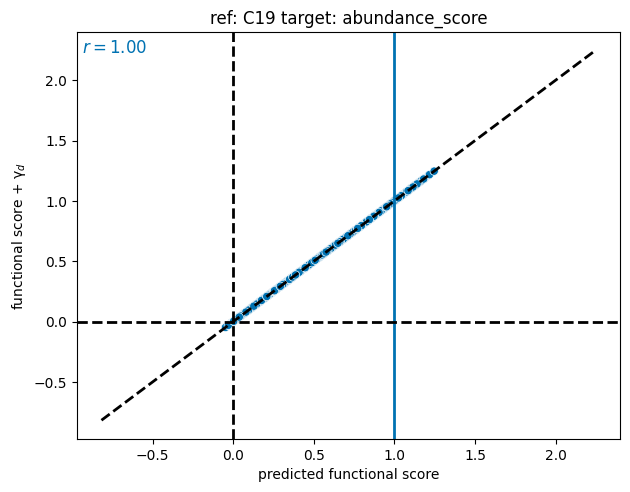

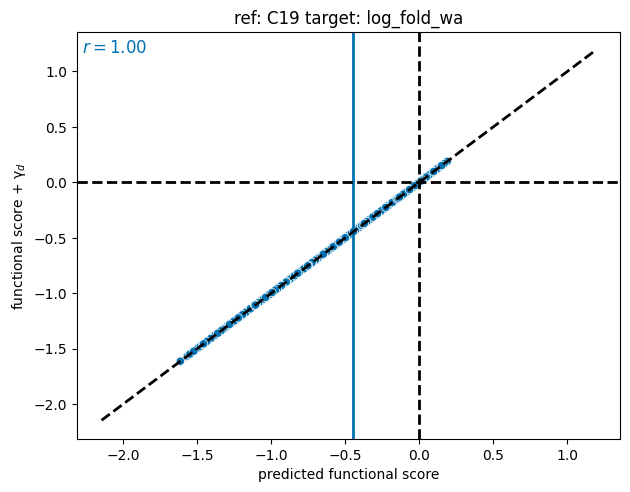

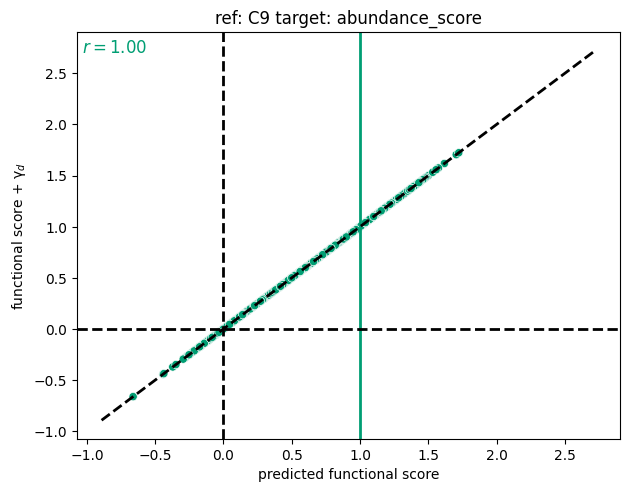

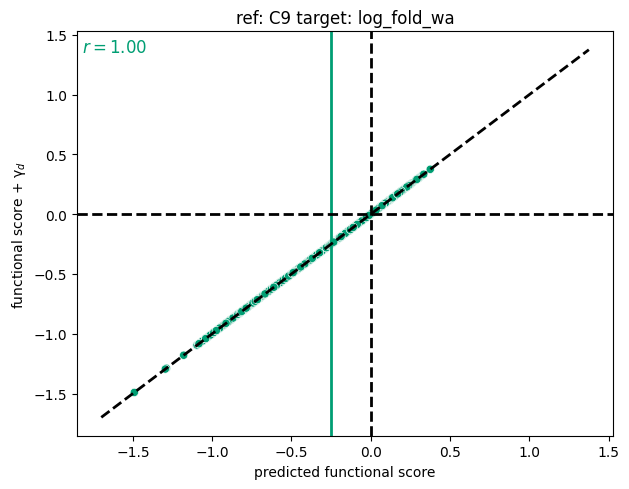

In [174]:
for model_idx, model_row in models.iterrows():
    fig, ax = plt.subplots()
    model_row.model_2000.plot_pred_accuracy(ax=ax, show=False, legend=False)
    ax.set_title(f"ref: {model_row.model_2000.data.reference} target: {datasets.loc[model_row.data_idx, 'target']}")
    plt.show()

## Fit Single Homolog Models (non-collapsed barcodes)

In [175]:
for data_idx, data_row in datasets.query("collapse_barcodes == False").iterrows():
    start_t = time.time()
    new_fit_params = fit_params.copy()
    new_fit_params["init_C_ref"] = 1.0 if data_row.target == "abundance_score" else 0.0
    new_fit_params["lock_C_ref"] = 1.0 if data_row.target == "abundance_score" else 0.0
    model = multidms.utils.fit_wrapper(data_row.data, **new_fit_params)
    model['data_idx'] = data_idx
    models = pd.concat([models, model], ignore_index=True)

running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7fefb40659c0>,
 'epistatic_model': 'Identity',
 'gamma_corrected': False,
 'init_C_ref': 1.0,
 'iterations_per_step': 200,
 'lock_C_ref': 1.0,
 'lock_beta': False,
 'num_training_steps': 10,
 'output_activation': 'Identity',
 'save_model_at': [2000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': False,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0,
 'λ_ridge_shift': 0}
training_step 0/10, Loss: 0.035173104575666074, Time: 8 Seconds
training_step 1/10, Loss: 0.035176854179626196, Time: 4 Seconds
training_step 2/10, Loss: 0.03517685418476117, Time: 4 Seconds
training_step 3/10, Loss: 0.03517685418989592, Time: 4 Seconds
training_step 4/10, Loss: 0.03517685419503045, Time: 5 Seconds
training_step 5/10, Loss: 0.03517685420016477, Time: 4 Seconds
training_step 6/10, Loss: 0.035176854205298855, T

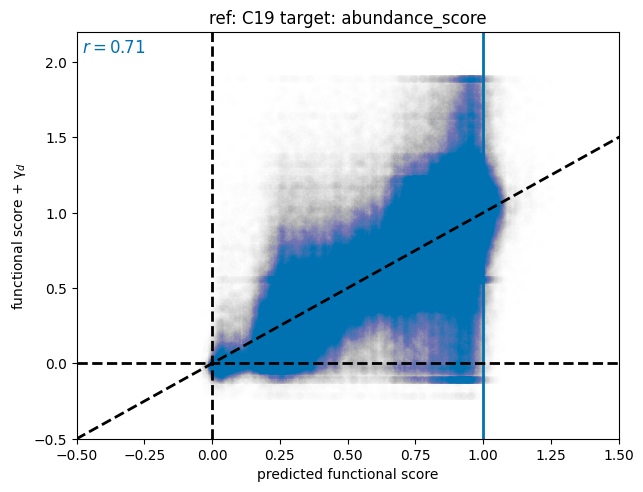

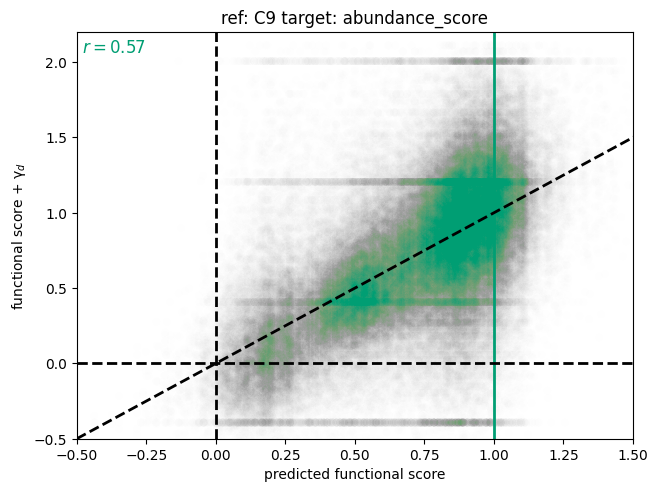

In [180]:
for model_idx, model_row in models.loc[4:].iterrows():
    if datasets.loc[model_row.data_idx, "target"] == "log_fold_wa": continue
    fig, ax = plt.subplots()
    model_row.model_2000.plot_pred_accuracy(ax=ax, show=False, legend=False, alpha=0.003)
    ax.set_title(f"ref: {model_row.model_2000.data.reference} target: {datasets.loc[model_row.data_idx, 'target']}")
    ax.set_ylim([-.5, 2.2])
    ax.set_xlim([-0.5, 1.5])
    plt.show()